<a href="https://colab.research.google.com/github/wildhugecoconut/RETAIL_ENTRE_NUCLIO/blob/main/ENTREGA_KAGGLE_NUCLIO_RETAIL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Objetivos del notebook
---
En el presente notebook vamos a aprender a utilizar el algoritmo de XGBoost para trabajar con Series Temporales.

[XGBoost](https://xgboost.readthedocs.io/en/stable/) es una implementación muy popular del [Gradient Boosting](https://interactivechaos.com/es/manual/tutorial-de-machine-learning/gradient-boosting) y se ha convertido **"de facto"** en el benchmark a batir para datos tabulares.

A pesar de tener sus carencias para problemas de Series Temporales (por ejemplo: no es capaz de extrapolar una tendencia), el algoritmo es muy versátil y todo Data Scientist debe conocerlo.

El dataset con el que vamos a trabajar en este notebook contiene un total de **426 Series Temporales** que abarcan el periodo Enero'2013 - Septiembre'2015. Por tanto vamos a trabajar con **Series Temporales Multivariante**.

Cada una de estas **Series Temporales** representan las ventas <u>**MENSUALES**</u> de **un artículo en un tienda y ciudad**. El objetivo es predecir las <u>**VENTAS TOTALES DEL MES DE OCTUBRE'2015**</u>.

Al final del notebook, el alumno debe estar familiarizado con:

1. **La importancia de establecer un benchmark (CORE IDEA)** cuando empezamos a trabajar en un problema de Machine Learning. <br>
2. Saber utilizar **pandas de forma eficiente para manipular el dataset (resample de pandas, groupby etc).** <br>
3. **Combinar la información de diferentes Series Temporales para generar variables (ventas totales de un artículo, ventas totales de todos los artículos en una tienda) con las que alimentar nuestro modelo XGBoost (CORE IDEA).**<br>
4. **Saber identificar las variables autoexplicativas (COREA IDEA)** y sus principales causas.<br>
5. Comprender **la importancia de iterar rápido (realizar muchos experimentos) (CORE IDEA)** para testear diferentes hipótesis y variables que se construyen.

---

El presente notebook contiene muchas funcionalidades avanzadas que puede requerir varias lecturas para su comprensión.
Pensamos que las secciones marcadas con **CORE IDEA** son las que mayor beneficio le reportarán al alumno. Por este motivo, le animamos a que dedique especial atención a estas ideas.

Al final del notebook, hay un sección de referencias y lecturas recomendables para que el alumno pueda seguir profundizando en estos conceptos.

---

<a id='index'></a>
### Índice

[Imports del notebook](#imports_notebook)<br>
[Data Loading](#data_load)<br>
[La idea del Benchmark (**CORE IDEA**)](#benchmark)<br>
[Data Imputation](#impute)<br>
[EDA](#eda)<br>
[--> 1. EDA: Global Sales](#eda_global_sales)<br>
[--> 2. EDA: Top 3 Cities](#eda_top_3_cities)<br>
[--> 3. EDA: Top 3 Categories](#eda_top_3_categories)<br>
[Build Time Series Features (**CORE IDEA**)](#build_ts_features)<br>
[Join TS Features](#join_ts_features)<br>
[Train Test Split](#train_test_split)<br>
[Model Train](#model_train)<br>
[Model Evaluation (**COREA IDEA**)](#model_evaluation)<br>
[Prediction](#prediction)<br>

### Conclusión
[Conclusión](#conclusion)<br>

### Referencias
[Referencias y lecturas recomendables](#referencias)<br>

<a id='imports_notebook'></a>
### Imports del notebook
[Volver al índice](#index)

En este apartado hacemos los principales imports del notebook.<br>
Sobre todo vamos a trabajar con **numpy**, **pandas**, **statsmodels** y **XGBoost**.

In [ ]:
import pickle
import os

from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv("/content/drive/MyDrive/machine learning/nuclio_2305/data/ts_kaggle_train.csv",index_col=0)

In [ ]:
df

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
1,2013-01-31,12_11369,16,12,9,11369,572.715278,30.0
2,2013-01-31,12_11370,16,12,9,11370,699.776786,30.0
3,2013-01-31,12_11373,16,12,9,11373,548.900000,6.0
4,2013-01-31,12_12231,16,12,49,12231,350.000000,3.0
...,...,...,...,...,...,...,...,...
14479,2015-10-31,7_5822,21,7,35,5822,NaN,NaN
14480,2015-10-31,7_6185,21,7,30,6185,NaN,NaN
14481,2015-10-31,7_6497,21,7,28,6497,NaN,NaN
14482,2015-10-31,7_7856,21,7,28,7856,NaN,NaN


In [ ]:
print("Working with these versions of libraries\n")
print(f"Numpy version {np.__version__}")
print(f"Pandas version {pd.__version__}")
print(f"XGBoost version {xgb.__version__}")

Working with these versions of libraries

Numpy version 1.23.5
Pandas version 1.5.3
XGBoost version 1.7.6


<a id='data_load'></a>
### Data Loading
[Volver al índice](#index)

Vamos a cargar nuestro dataset para comenzar con el EDA.

Vamos a ver que tipo de datos tenemos en nuestro dataset.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14484 entries, 0 to 14483
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   14484 non-null  object 
 1   unique_id              14484 non-null  object 
 2   city_id                14484 non-null  int64  
 3   shop_id                14484 non-null  int64  
 4   item_category_id       14484 non-null  int64  
 5   item_id                14484 non-null  int64  
 6   monthly_average_price  13262 non-null  float64
 7   monthly_sales          13756 non-null  float64
dtypes: float64(2), int64(4), object(2)
memory usage: 1018.4+ KB


In [ ]:
df["date"] = pd.to_datetime(df["date"], format = "%Y-%m-%d")

In [ ]:
df["date"]=df["date"].sort_values()

In [ ]:
df

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
1,2013-01-31,12_11369,16,12,9,11369,572.715278,30.0
2,2013-01-31,12_11370,16,12,9,11370,699.776786,30.0
3,2013-01-31,12_11373,16,12,9,11373,548.900000,6.0
4,2013-01-31,12_12231,16,12,49,12231,350.000000,3.0
...,...,...,...,...,...,...,...,...
14479,2015-10-31,7_5822,21,7,35,5822,NaN,NaN
14480,2015-10-31,7_6185,21,7,30,6185,NaN,NaN
14481,2015-10-31,7_6497,21,7,28,6497,NaN,NaN
14482,2015-10-31,7_7856,21,7,28,7856,NaN,NaN


<a id='benchmark'></a>
### La idea del Benchmark (CORE IDEA)
[Volver al índice](#index)

En el presente notebook buscamos establecer un benchmark rápido.

El motivo fundamental es porque los datasets en la vida real son muy complejos y no tenemos el "lujo" de poder analizar todas y cada una de las variables <u>**ANTES DE ENTRENAR NUESTRO PRIMER MODELO.</u>**

Establecer un benchmark nos ayuda a entender cual es el punto de partida, es decir: <u>**cual es el score mínimo para este dataset.**</u>

Muchas veces este benchmark puede ser un modelo entrenado con unas pocas columnas númericas (imputando los nulos con la media). <u>**No se trata de tener el mejor modelo sino de entrenar nuestro primer modelo.**</u>

Una vez sabemos cual es el punto de partida y tenemos un notebook **"funcional"** podemos empezar a experimentar con nuestro dataset. Por **"notebook funcional"** entendemos un script/notebook que podemos ejecutar en su totalidad (loading del dataset, preprocessing, train_test_split, train y predict). En cada experimento iremos añadiendo nuevas variables, diferentes imputaciones, modelos y vamos guardando el score que obtenemos. De este manera, podemos ver la contribución de cada variables y comprobar si estamos mejorando o no respecto al benchmark.

Dado que este notebook es un benchmark, tenemos que **"acotar"** muy bien las cosas que vamos a implementar (para no irnos por las ramas).

A **grosso modo** vamos a hacer las siguientes cosas:

1. Tratar los nulos.
1. Realizar un pequeño EDA sobre el dataset.
1. Crear algunas variables rápidas para el entrenamiento.
1. Entrenar el algoritmo.
1. Evaluar el modelo.
1. Hacer el submit a Kaggle.

Empecemos:

Tenemos un total de 426 Series Temporales en el dataset:

In [ ]:
df["unique_id"].nunique()

426

Veamos cuales son las fechas min y max de nuestro dataset:

In [ ]:
MIN_DATE = df["date"].min()
MAX_DATE = df["date"].max()

In [ ]:
print(f"Min date is {MIN_DATE}\nMax date is {MAX_DATE}")

Min date is 2013-01-31 00:00:00
Max date is 2015-10-31 00:00:00


In [ ]:
df.isnull().sum()

date                        0
unique_id                   0
city_id                     0
shop_id                     0
item_category_id            0
item_id                     0
monthly_average_price    1222
monthly_sales             728
dtype: int64

In [ ]:
df

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
1,2013-01-31,12_11369,16,12,9,11369,572.715278,30.0
2,2013-01-31,12_11370,16,12,9,11370,699.776786,30.0
3,2013-01-31,12_11373,16,12,9,11373,548.900000,6.0
4,2013-01-31,12_12231,16,12,49,12231,350.000000,3.0
...,...,...,...,...,...,...,...,...
14479,2015-10-31,7_5822,21,7,35,5822,NaN,NaN
14480,2015-10-31,7_6185,21,7,30,6185,NaN,NaN
14481,2015-10-31,7_6497,21,7,28,6497,NaN,NaN
14482,2015-10-31,7_7856,21,7,28,7856,NaN,NaN


<a id='impute'></a>
### Data Imputation
[Volver al índice](#index)<br>

In [ ]:
df["monthly_sales"].fillna(-999, inplace = True)

In [ ]:
df["monthly_average_price"] = df.groupby(["unique_id"])["monthly_average_price"].transform(
    lambda series: series.backfill().ffill()
)

In [ ]:
#df.sort_values(["unique_id", "date"], ascending = True, inplace = True)

In [ ]:
df["monthly_revenue"]=df["monthly_average_price"]*df["monthly_sales"]
df.head()

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,monthly_revenue
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,45345.378788
1,2013-01-31,12_11369,16,12,9,11369,572.715278,30.0,17181.458333
2,2013-01-31,12_11370,16,12,9,11370,699.776786,30.0,20993.303571
3,2013-01-31,12_11373,16,12,9,11373,548.900000,6.0,3293.400000
4,2013-01-31,12_12231,16,12,49,12231,350.000000,3.0,1050.000000


In [ ]:
def build_ts_features(df,gb_list,target_column):
  new_name="".join(gb_list+[target_column])
  gb=(
    df
    .set_index("date")
    .groupby(gb_list)
    .resample("M")
    [target_column].sum()
    .to_frame()
    .reset_index()
    .rename(
        columns={
            target_column: new_name
        }
    )
  )



  return gb

In [ ]:
df

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,monthly_revenue
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,4.534538e+04
1,2013-01-31,12_11369,16,12,9,11369,572.715278,30.0,1.718146e+04
2,2013-01-31,12_11370,16,12,9,11370,699.776786,30.0,2.099330e+04
3,2013-01-31,12_11373,16,12,9,11373,548.900000,6.0,3.293400e+03
4,2013-01-31,12_12231,16,12,49,12231,350.000000,3.0,1.050000e+03
...,...,...,...,...,...,...,...,...,...
14479,2015-10-31,7_5822,21,7,35,5822,1149.000000,-999.0,-1.147851e+06
14480,2015-10-31,7_6185,21,7,30,6185,499.000000,-999.0,-4.985010e+05
14481,2015-10-31,7_6497,21,7,28,6497,749.000000,-999.0,-7.482510e+05
14482,2015-10-31,7_7856,21,7,28,7856,1199.000000,-999.0,-1.197801e+06


In [ ]:
gb= build_ts_features(
    df=df,
    gb_list=["shop_id"],
    target_column="monthly_revenue"
)
gb

,shop_id,date,shop_idmonthly_revenue
0,3,2013-01-31,2.489000e+03
1,3,2013-02-28,9.990000e+02
2,3,2013-03-31,1.049000e+03
3,3,2013-04-30,1.048500e+03
4,3,2013-05-31,3.588000e+03
...,...,...,...
1185,59,2015-06-30,3.234000e+03
1186,59,2015-07-31,6.030000e+03
1187,59,2015-08-31,1.017829e+04
1188,59,2015-09-30,4.258000e+03


In [ ]:
df=pd.merge(df,gb,on=["date","shop_id"],how="left")

In [ ]:
def new_gb(gb, gb_list, new_name):
    gb[f"{new_name}_lag1"] = gb.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(1)
    )
    gb[f"{new_name}_lag2"] = gb.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(2)
    )
    gb[f"{new_name}_lag3"] = gb.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(3)
    )
    return gb


In [ ]:
df= new_gb(
    gb=df,
    gb_list="shop_id",
    new_name="shop_idmonthly_revenue"
)
df

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,monthly_revenue,shop_idmonthly_revenue,shop_idmonthly_revenue_lag1,shop_idmonthly_revenue_lag2,shop_idmonthly_revenue_lag3
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,4.534538e+04,2.132635e+05,NaN,NaN,NaN
1,2013-01-31,12_11369,16,12,9,11369,572.715278,30.0,1.718146e+04,2.132635e+05,2.132635e+05,NaN,NaN
2,2013-01-31,12_11370,16,12,9,11370,699.776786,30.0,2.099330e+04,2.132635e+05,2.132635e+05,2.132635e+05,NaN
3,2013-01-31,12_11373,16,12,9,11373,548.900000,6.0,3.293400e+03,2.132635e+05,2.132635e+05,2.132635e+05,2.132635e+05
4,2013-01-31,12_12231,16,12,49,12231,350.000000,3.0,1.050000e+03,2.132635e+05,2.132635e+05,2.132635e+05,2.132635e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14479,2015-10-31,7_5822,21,7,35,5822,1149.000000,-999.0,-1.147851e+06,-1.182613e+07,-1.182613e+07,-1.182613e+07,-1.182613e+07
14480,2015-10-31,7_6185,21,7,30,6185,499.000000,-999.0,-4.985010e+05,-1.182613e+07,-1.182613e+07,-1.182613e+07,-1.182613e+07
14481,2015-10-31,7_6497,21,7,28,6497,749.000000,-999.0,-7.482510e+05,-1.182613e+07,-1.182613e+07,-1.182613e+07,-1.182613e+07
14482,2015-10-31,7_7856,21,7,28,7856,1199.000000,-999.0,-1.197801e+06,-1.182613e+07,-1.182613e+07,-1.182613e+07,-1.182613e+07


In [ ]:
gb1= build_ts_features(
    df=df,
    gb_list=["item_category_id"],
    target_column="monthly_revenue"
)
gb1

,item_category_id,date,item_category_idmonthly_revenue
0,2,2013-01-31,109576.818333
1,2,2013-02-28,95599.333333
2,2,2013-03-31,52579.500000
3,2,2013-04-30,49290.000000
4,2,2013-05-31,78087.821429
...,...,...,...
947,83,2015-06-30,2499.000000
948,83,2015-07-31,3094.000000
949,83,2015-08-31,3451.000000
950,83,2015-09-30,3094.000000


In [ ]:
df=pd.merge(df,gb1,on=["date","item_category_id"],how="left")

In [ ]:
df= new_gb(
    gb=df,
    gb_list="item_category_id",
    new_name="item_category_idmonthly_revenue"
)
df

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,monthly_revenue,shop_idmonthly_revenue,shop_idmonthly_revenue_lag1,shop_idmonthly_revenue_lag2,shop_idmonthly_revenue_lag3,item_category_idmonthly_revenue,item_category_idmonthly_revenue_lag1,item_category_idmonthly_revenue_lag2,item_category_idmonthly_revenue_lag3
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,4.534538e+04,2.132635e+05,NaN,NaN,NaN,8.681354e+04,NaN,NaN,NaN
1,2013-01-31,12_11369,16,12,9,11369,572.715278,30.0,1.718146e+04,2.132635e+05,2.132635e+05,NaN,NaN,8.681354e+04,8.681354e+04,NaN,NaN
2,2013-01-31,12_11370,16,12,9,11370,699.776786,30.0,2.099330e+04,2.132635e+05,2.132635e+05,2.132635e+05,NaN,8.681354e+04,8.681354e+04,86813.540693,NaN
3,2013-01-31,12_11373,16,12,9,11373,548.900000,6.0,3.293400e+03,2.132635e+05,2.132635e+05,2.132635e+05,2.132635e+05,8.681354e+04,8.681354e+04,86813.540693,86813.540693
4,2013-01-31,12_12231,16,12,49,12231,350.000000,3.0,1.050000e+03,2.132635e+05,2.132635e+05,2.132635e+05,2.132635e+05,2.521226e+04,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14479,2015-10-31,7_5822,21,7,35,5822,1149.000000,-999.0,-1.147851e+06,-1.182613e+07,-1.182613e+07,-1.182613e+07,-1.182613e+07,-1.273026e+08,8.256437e+05,830138.492370,627293.250000
14480,2015-10-31,7_6185,21,7,30,6185,499.000000,-999.0,-4.985010e+05,-1.182613e+07,-1.182613e+07,-1.182613e+07,-1.182613e+07,-3.692248e+07,-3.692248e+07,90001.875000,90001.875000
14481,2015-10-31,7_6497,21,7,28,6497,749.000000,-999.0,-7.482510e+05,-1.182613e+07,-1.182613e+07,-1.182613e+07,-1.182613e+07,-2.378062e+07,7.418502e+04,74185.025000,101782.513889
14482,2015-10-31,7_7856,21,7,28,7856,1199.000000,-999.0,-1.197801e+06,-1.182613e+07,-1.182613e+07,-1.182613e+07,-1.182613e+07,-2.378062e+07,-2.378062e+07,74185.025000,74185.025000


In [ ]:
gb2= build_ts_features(
    df=df,
    gb_list=["city_id"],
    target_column="monthly_revenue"
)

df=pd.merge(df,gb2,on=["date","city_id"],how="left")

df= new_gb(
    gb=df,
    gb_list="city_id",
    new_name="city_idmonthly_revenue"
)
df


,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,monthly_revenue,shop_idmonthly_revenue,...,shop_idmonthly_revenue_lag2,shop_idmonthly_revenue_lag3,item_category_idmonthly_revenue,item_category_idmonthly_revenue_lag1,item_category_idmonthly_revenue_lag2,item_category_idmonthly_revenue_lag3,city_idmonthly_revenue,city_idmonthly_revenue_lag1,city_idmonthly_revenue_lag2,city_idmonthly_revenue_lag3
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,4.534538e+04,2.132635e+05,...,NaN,NaN,8.681354e+04,NaN,NaN,NaN,-2.953566e+06,NaN,NaN,NaN
1,2013-01-31,12_11369,16,12,9,11369,572.715278,30.0,1.718146e+04,2.132635e+05,...,NaN,NaN,8.681354e+04,8.681354e+04,NaN,NaN,-2.953566e+06,-2.953566e+06,NaN,NaN
2,2013-01-31,12_11370,16,12,9,11370,699.776786,30.0,2.099330e+04,2.132635e+05,...,2.132635e+05,NaN,8.681354e+04,8.681354e+04,86813.540693,NaN,-2.953566e+06,-2.953566e+06,-2.953566e+06,NaN
3,2013-01-31,12_11373,16,12,9,11373,548.900000,6.0,3.293400e+03,2.132635e+05,...,2.132635e+05,2.132635e+05,8.681354e+04,8.681354e+04,86813.540693,86813.540693,-2.953566e+06,-2.953566e+06,-2.953566e+06,-2.953566e+06
4,2013-01-31,12_12231,16,12,49,12231,350.000000,3.0,1.050000e+03,2.132635e+05,...,2.132635e+05,2.132635e+05,2.521226e+04,NaN,NaN,NaN,-2.953566e+06,-2.953566e+06,-2.953566e+06,-2.953566e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14479,2015-10-31,7_5822,21,7,35,5822,1149.000000,-999.0,-1.147851e+06,-1.182613e+07,...,-1.182613e+07,-1.182613e+07,-1.273026e+08,8.256437e+05,830138.492370,627293.250000,-2.322754e+07,-2.322754e+07,-2.322754e+07,-2.322754e+07
14480,2015-10-31,7_6185,21,7,30,6185,499.000000,-999.0,-4.985010e+05,-1.182613e+07,...,-1.182613e+07,-1.182613e+07,-3.692248e+07,-3.692248e+07,90001.875000,90001.875000,-2.322754e+07,-2.322754e+07,-2.322754e+07,-2.322754e+07
14481,2015-10-31,7_6497,21,7,28,6497,749.000000,-999.0,-7.482510e+05,-1.182613e+07,...,-1.182613e+07,-1.182613e+07,-2.378062e+07,7.418502e+04,74185.025000,101782.513889,-2.322754e+07,-2.322754e+07,-2.322754e+07,-2.322754e+07
14482,2015-10-31,7_7856,21,7,28,7856,1199.000000,-999.0,-1.197801e+06,-1.182613e+07,...,-1.182613e+07,-1.182613e+07,-2.378062e+07,-2.378062e+07,74185.025000,74185.025000,-2.322754e+07,-2.322754e+07,-2.322754e+07,-2.322754e+07


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14484 entries, 0 to 14483
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  14484 non-null  datetime64[ns]
 1   unique_id                             14484 non-null  object        
 2   city_id                               14484 non-null  int64         
 3   shop_id                               14484 non-null  int64         
 4   item_category_id                      14484 non-null  int64         
 5   item_id                               14484 non-null  int64         
 6   monthly_average_price                 14484 non-null  float64       
 7   monthly_sales                         14484 non-null  float64       
 8   monthly_revenue                       14484 non-null  float64       
 9   shop_idmonthly_revenue                14484 non-null  float64       
 10

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14484 entries, 0 to 14483
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  14484 non-null  datetime64[ns]
 1   unique_id                             14484 non-null  object        
 2   city_id                               14484 non-null  int64         
 3   shop_id                               14484 non-null  int64         
 4   item_category_id                      14484 non-null  int64         
 5   item_id                               14484 non-null  int64         
 6   monthly_average_price                 14484 non-null  float64       
 7   monthly_sales                         14484 non-null  float64       
 8   monthly_revenue                       14484 non-null  float64       
 9   shop_idmonthly_revenue                14484 non-null  float64       
 10

In [ ]:
gbm1= build_ts_features(
    df=df,
    gb_list=["city_id"],
    target_column="monthly_sales"
)

df=pd.merge(df,gbm1,on=["date","city_id"],how="left")

df= new_gb(
    gb=df,
    gb_list="city_id",
    new_name="city_idmonthly_sales"
)
df



,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,monthly_revenue,shop_idmonthly_revenue,...,item_category_idmonthly_revenue_lag2,item_category_idmonthly_revenue_lag3,city_idmonthly_revenue,city_idmonthly_revenue_lag1,city_idmonthly_revenue_lag2,city_idmonthly_revenue_lag3,city_idmonthly_sales,city_idmonthly_sales_lag1,city_idmonthly_sales_lag2,city_idmonthly_sales_lag3
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,4.534538e+04,2.132635e+05,...,NaN,NaN,-2.953566e+06,NaN,NaN,NaN,-8854.0,NaN,NaN,NaN
1,2013-01-31,12_11369,16,12,9,11369,572.715278,30.0,1.718146e+04,2.132635e+05,...,NaN,NaN,-2.953566e+06,-2.953566e+06,NaN,NaN,-8854.0,-8854.0,NaN,NaN
2,2013-01-31,12_11370,16,12,9,11370,699.776786,30.0,2.099330e+04,2.132635e+05,...,86813.540693,NaN,-2.953566e+06,-2.953566e+06,-2.953566e+06,NaN,-8854.0,-8854.0,-8854.0,NaN
3,2013-01-31,12_11373,16,12,9,11373,548.900000,6.0,3.293400e+03,2.132635e+05,...,86813.540693,86813.540693,-2.953566e+06,-2.953566e+06,-2.953566e+06,-2.953566e+06,-8854.0,-8854.0,-8854.0,-8854.0
4,2013-01-31,12_12231,16,12,49,12231,350.000000,3.0,1.050000e+03,2.132635e+05,...,NaN,NaN,-2.953566e+06,-2.953566e+06,-2.953566e+06,-2.953566e+06,-8854.0,-8854.0,-8854.0,-8854.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14479,2015-10-31,7_5822,21,7,35,5822,1149.000000,-999.0,-1.147851e+06,-1.182613e+07,...,830138.492370,627293.250000,-2.322754e+07,-2.322754e+07,-2.322754e+07,-2.322754e+07,-20979.0,-20979.0,-20979.0,-20979.0
14480,2015-10-31,7_6185,21,7,30,6185,499.000000,-999.0,-4.985010e+05,-1.182613e+07,...,90001.875000,90001.875000,-2.322754e+07,-2.322754e+07,-2.322754e+07,-2.322754e+07,-20979.0,-20979.0,-20979.0,-20979.0
14481,2015-10-31,7_6497,21,7,28,6497,749.000000,-999.0,-7.482510e+05,-1.182613e+07,...,74185.025000,101782.513889,-2.322754e+07,-2.322754e+07,-2.322754e+07,-2.322754e+07,-20979.0,-20979.0,-20979.0,-20979.0
14482,2015-10-31,7_7856,21,7,28,7856,1199.000000,-999.0,-1.197801e+06,-1.182613e+07,...,74185.025000,74185.025000,-2.322754e+07,-2.322754e+07,-2.322754e+07,-2.322754e+07,-20979.0,-20979.0,-20979.0,-20979.0


In [ ]:
gbm2= build_ts_features(
    df=df,
    gb_list=["item_id"],
    target_column="monthly_sales"
)

df=pd.merge(df,gbm2,on=["date","item_id"],how="left")

df= new_gb(
    gb=df,
    gb_list="item_id",
    new_name="item_idmonthly_sales"
)
df


,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,monthly_revenue,shop_idmonthly_revenue,...,city_idmonthly_revenue_lag2,city_idmonthly_revenue_lag3,city_idmonthly_sales,city_idmonthly_sales_lag1,city_idmonthly_sales_lag2,city_idmonthly_sales_lag3,item_idmonthly_sales,item_idmonthly_sales_lag1,item_idmonthly_sales_lag2,item_idmonthly_sales_lag3
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,4.534538e+04,2.132635e+05,...,NaN,NaN,-8854.0,NaN,NaN,NaN,30.0,NaN,NaN,NaN
1,2013-01-31,12_11369,16,12,9,11369,572.715278,30.0,1.718146e+04,2.132635e+05,...,NaN,NaN,-8854.0,-8854.0,NaN,NaN,30.0,NaN,NaN,NaN
2,2013-01-31,12_11370,16,12,9,11370,699.776786,30.0,2.099330e+04,2.132635e+05,...,-2.953566e+06,NaN,-8854.0,-8854.0,-8854.0,NaN,30.0,NaN,NaN,NaN
3,2013-01-31,12_11373,16,12,9,11373,548.900000,6.0,3.293400e+03,2.132635e+05,...,-2.953566e+06,-2.953566e+06,-8854.0,-8854.0,-8854.0,-8854.0,6.0,NaN,NaN,NaN
4,2013-01-31,12_12231,16,12,49,12231,350.000000,3.0,1.050000e+03,2.132635e+05,...,-2.953566e+06,-2.953566e+06,-8854.0,-8854.0,-8854.0,-8854.0,3.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14479,2015-10-31,7_5822,21,7,35,5822,1149.000000,-999.0,-1.147851e+06,-1.182613e+07,...,-2.322754e+07,-2.322754e+07,-20979.0,-20979.0,-20979.0,-20979.0,-27972.0,244.0,252.0,186.0
14480,2015-10-31,7_6185,21,7,30,6185,499.000000,-999.0,-4.985010e+05,-1.182613e+07,...,-2.322754e+07,-2.322754e+07,-20979.0,-20979.0,-20979.0,-20979.0,-7992.0,19.0,35.0,26.0
14481,2015-10-31,7_6497,21,7,28,6497,749.000000,-999.0,-7.482510e+05,-1.182613e+07,...,-2.322754e+07,-2.322754e+07,-20979.0,-20979.0,-20979.0,-20979.0,-4995.0,31.0,39.0,20.0
14482,2015-10-31,7_7856,21,7,28,7856,1199.000000,-999.0,-1.197801e+06,-1.182613e+07,...,-2.322754e+07,-2.322754e+07,-20979.0,-20979.0,-20979.0,-20979.0,-15984.0,40.0,52.0,43.0


In [ ]:
gbm3= build_ts_features(
    df=df,
    gb_list=["item_category_id"],
    target_column="monthly_sales"
)

df=pd.merge(df,gbm3,on=["date","item_category_id"],how="left")

df= new_gb(
    gb=df,
    gb_list="item_category_id",
    new_name="item_category_idmonthly_sales"
)
df


,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,monthly_revenue,shop_idmonthly_revenue,...,city_idmonthly_sales_lag2,city_idmonthly_sales_lag3,item_idmonthly_sales,item_idmonthly_sales_lag1,item_idmonthly_sales_lag2,item_idmonthly_sales_lag3,item_category_idmonthly_sales,item_category_idmonthly_sales_lag1,item_category_idmonthly_sales_lag2,item_category_idmonthly_sales_lag3
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,4.534538e+04,2.132635e+05,...,NaN,NaN,30.0,NaN,NaN,NaN,96.0,NaN,NaN,NaN
1,2013-01-31,12_11369,16,12,9,11369,572.715278,30.0,1.718146e+04,2.132635e+05,...,NaN,NaN,30.0,NaN,NaN,NaN,96.0,96.0,NaN,NaN
2,2013-01-31,12_11370,16,12,9,11370,699.776786,30.0,2.099330e+04,2.132635e+05,...,-8854.0,NaN,30.0,NaN,NaN,NaN,96.0,96.0,96.0,NaN
3,2013-01-31,12_11373,16,12,9,11373,548.900000,6.0,3.293400e+03,2.132635e+05,...,-8854.0,-8854.0,6.0,NaN,NaN,NaN,96.0,96.0,96.0,96.0
4,2013-01-31,12_12231,16,12,49,12231,350.000000,3.0,1.050000e+03,2.132635e+05,...,-8854.0,-8854.0,3.0,NaN,NaN,NaN,77.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14479,2015-10-31,7_5822,21,7,35,5822,1149.000000,-999.0,-1.147851e+06,-1.182613e+07,...,-20979.0,-20979.0,-27972.0,244.0,252.0,186.0,-73926.0,512.0,507.0,410.0
14480,2015-10-31,7_6185,21,7,30,6185,499.000000,-999.0,-4.985010e+05,-1.182613e+07,...,-20979.0,-20979.0,-7992.0,19.0,35.0,26.0,-85914.0,-85914.0,241.0,241.0
14481,2015-10-31,7_6497,21,7,28,6497,749.000000,-999.0,-7.482510e+05,-1.182613e+07,...,-20979.0,-20979.0,-4995.0,31.0,39.0,20.0,-20979.0,71.0,71.0,91.0
14482,2015-10-31,7_7856,21,7,28,7856,1199.000000,-999.0,-1.197801e+06,-1.182613e+07,...,-20979.0,-20979.0,-15984.0,40.0,52.0,43.0,-20979.0,-20979.0,71.0,71.0


In [ ]:
gbm4= build_ts_features(
    df=df,
    gb_list=["shop_id"],
    target_column="monthly_sales"
)

df=pd.merge(df,gbm4,on=["date","shop_id"],how="left")

df= new_gb(
    gb=df,
    gb_list="shop_id",
    new_name="shop_idmonthly_sales"
)
df


,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,monthly_revenue,shop_idmonthly_revenue,...,item_idmonthly_sales_lag2,item_idmonthly_sales_lag3,item_category_idmonthly_sales,item_category_idmonthly_sales_lag1,item_category_idmonthly_sales_lag2,item_category_idmonthly_sales_lag3,shop_idmonthly_sales,shop_idmonthly_sales_lag1,shop_idmonthly_sales_lag2,shop_idmonthly_sales_lag3
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,4.534538e+04,2.132635e+05,...,NaN,NaN,96.0,NaN,NaN,NaN,137.0,NaN,NaN,NaN
1,2013-01-31,12_11369,16,12,9,11369,572.715278,30.0,1.718146e+04,2.132635e+05,...,NaN,NaN,96.0,96.0,NaN,NaN,137.0,137.0,NaN,NaN
2,2013-01-31,12_11370,16,12,9,11370,699.776786,30.0,2.099330e+04,2.132635e+05,...,NaN,NaN,96.0,96.0,96.0,NaN,137.0,137.0,137.0,NaN
3,2013-01-31,12_11373,16,12,9,11373,548.900000,6.0,3.293400e+03,2.132635e+05,...,NaN,NaN,96.0,96.0,96.0,96.0,137.0,137.0,137.0,137.0
4,2013-01-31,12_12231,16,12,49,12231,350.000000,3.0,1.050000e+03,2.132635e+05,...,NaN,NaN,77.0,NaN,NaN,NaN,137.0,137.0,137.0,137.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14479,2015-10-31,7_5822,21,7,35,5822,1149.000000,-999.0,-1.147851e+06,-1.182613e+07,...,252.0,186.0,-73926.0,512.0,507.0,410.0,-11988.0,-11988.0,-11988.0,-11988.0
14480,2015-10-31,7_6185,21,7,30,6185,499.000000,-999.0,-4.985010e+05,-1.182613e+07,...,35.0,26.0,-85914.0,-85914.0,241.0,241.0,-11988.0,-11988.0,-11988.0,-11988.0
14481,2015-10-31,7_6497,21,7,28,6497,749.000000,-999.0,-7.482510e+05,-1.182613e+07,...,39.0,20.0,-20979.0,71.0,71.0,91.0,-11988.0,-11988.0,-11988.0,-11988.0
14482,2015-10-31,7_7856,21,7,28,7856,1199.000000,-999.0,-1.197801e+06,-1.182613e+07,...,52.0,43.0,-20979.0,-20979.0,71.0,71.0,-11988.0,-11988.0,-11988.0,-11988.0


<a id='eda'></a>
### EDA
[Volver al índice](#index)<br>

Vamos a hacer un EDA rápido para ver como son nuestras Series Temporales y coger algunas ideas para futuras variables que vamos a implementar.

Al tratarse este notebook del benchmark, vamos a explorar de manera muy superficial el dataset. En posteriores ejecuciones analizaremos el dataset en más detalle, construiremos nuevas variables y volveremos a entrenar nuestro modelo.

In [ ]:
'''
import pickle
import os

from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
'''

'\nimport pickle\nimport os\n\nfrom datetime import datetime\nimport pandas as pd\nimport numpy as np\n\nimport matplotlib.pyplot as plt\n%matplotlib inline\n\nfrom sklearn.metrics import mean_squared_error\nfrom sklearn.preprocessing import OrdinalEncoder\n\nimport xgboost as xgb\n\nfrom statsmodels.graphics.tsaplots import plot_acf, plot_pacf\n'

In [ ]:
#df=pd.read_pickle("/content/drive/MyDrive/Nuclio Capstone Project/pickle_de_nico")

In [ ]:
df

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,monthly_revenue,shop_idmonthly_revenue,...,item_idmonthly_sales_lag2,item_idmonthly_sales_lag3,item_category_idmonthly_sales,item_category_idmonthly_sales_lag1,item_category_idmonthly_sales_lag2,item_category_idmonthly_sales_lag3,shop_idmonthly_sales,shop_idmonthly_sales_lag1,shop_idmonthly_sales_lag2,shop_idmonthly_sales_lag3
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,4.534538e+04,2.132635e+05,...,NaN,NaN,96.0,NaN,NaN,NaN,137.0,NaN,NaN,NaN
1,2013-01-31,12_11369,16,12,9,11369,572.715278,30.0,1.718146e+04,2.132635e+05,...,NaN,NaN,96.0,96.0,NaN,NaN,137.0,137.0,NaN,NaN
2,2013-01-31,12_11370,16,12,9,11370,699.776786,30.0,2.099330e+04,2.132635e+05,...,NaN,NaN,96.0,96.0,96.0,NaN,137.0,137.0,137.0,NaN
3,2013-01-31,12_11373,16,12,9,11373,548.900000,6.0,3.293400e+03,2.132635e+05,...,NaN,NaN,96.0,96.0,96.0,96.0,137.0,137.0,137.0,137.0
4,2013-01-31,12_12231,16,12,49,12231,350.000000,3.0,1.050000e+03,2.132635e+05,...,NaN,NaN,77.0,NaN,NaN,NaN,137.0,137.0,137.0,137.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14479,2015-10-31,7_5822,21,7,35,5822,1149.000000,-999.0,-1.147851e+06,-1.182613e+07,...,252.0,186.0,-73926.0,512.0,507.0,410.0,-11988.0,-11988.0,-11988.0,-11988.0
14480,2015-10-31,7_6185,21,7,30,6185,499.000000,-999.0,-4.985010e+05,-1.182613e+07,...,35.0,26.0,-85914.0,-85914.0,241.0,241.0,-11988.0,-11988.0,-11988.0,-11988.0
14481,2015-10-31,7_6497,21,7,28,6497,749.000000,-999.0,-7.482510e+05,-1.182613e+07,...,39.0,20.0,-20979.0,71.0,71.0,91.0,-11988.0,-11988.0,-11988.0,-11988.0
14482,2015-10-31,7_7856,21,7,28,7856,1199.000000,-999.0,-1.197801e+06,-1.182613e+07,...,52.0,43.0,-20979.0,-20979.0,71.0,71.0,-11988.0,-11988.0,-11988.0,-11988.0


<a id='eda_global_sales'></a>
### --> 1. EDA: Global Sales
[Volver al índice](#index)<br>

<a id='eda_top_3_cities'></a>
### --> 2. EDA: Top 3 Cities
[Volver al índice](#index)<br>

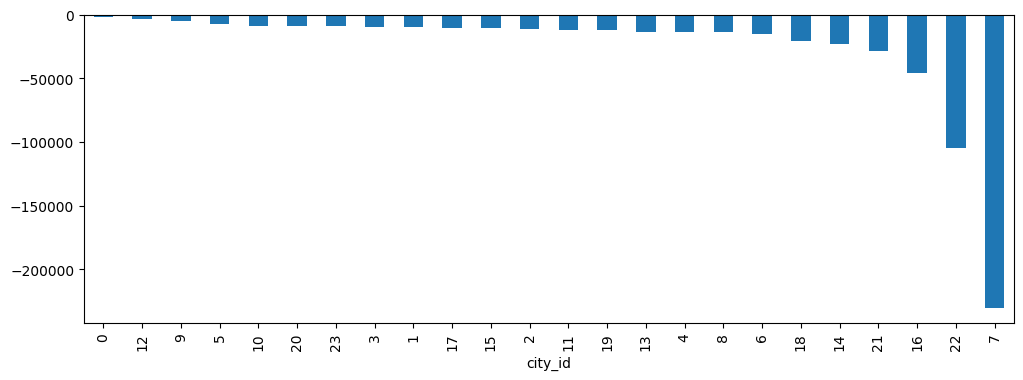

In [ ]:
(
    df.
    groupby(["city_id"])
    ["monthly_sales"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

<a id='eda_top_3_categories'></a>
### --> 3. EDA: Top 3 Categories
[Volver al índice](#index)<br>

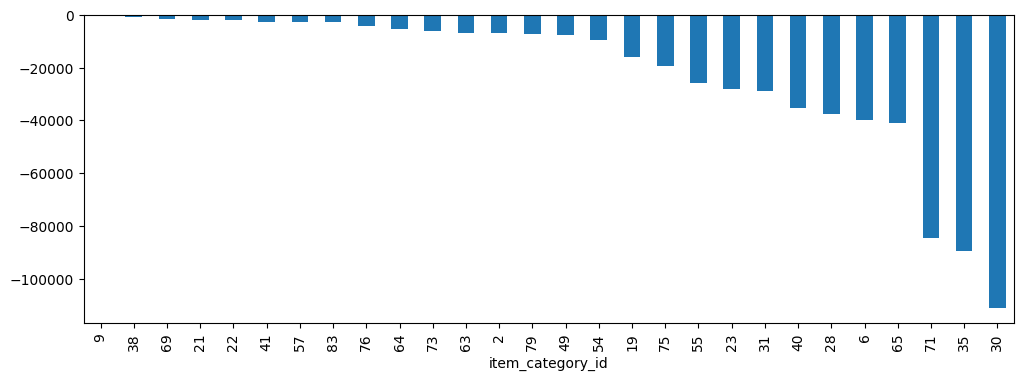

In [ ]:
(
    df.
    groupby(["item_category_id"])
    ["monthly_sales"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

<a id='build_ts_features'></a>
### Build Time Series Features (**CORE IDEA**)
[Volver al índice](#index)<br>

Dado que vamos a tener que iterar muchas veces sobre nuestro dataset, nos interesa tener todo el código encapsulado en funciones para su reutilización.

Uno de los apartados clave será la generación de variables.

Como hemos visto antes, nuestro dataset contiene más de 400 Series Temporales.

Algunas de estas Series Temporales las podemos agrupar para sacar nueva información.

Por ejemplo, podemos construir una variables del estilo:

1. Las ventas totales por ITEM_ID (la menor granularidad posible).
2. Las ventas totales por ITEM_CATEGORY_ID y SHOP_ID (una granularidad mayor a la 1).
3. Las ventas totales por SHOP_ID (una granularidad mayor).
4. Y todas las combinaciones que queramos intermedias.

In [ ]:
df

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,monthly_revenue,shop_idmonthly_revenue,...,item_idmonthly_sales_lag2,item_idmonthly_sales_lag3,item_category_idmonthly_sales,item_category_idmonthly_sales_lag1,item_category_idmonthly_sales_lag2,item_category_idmonthly_sales_lag3,shop_idmonthly_sales,shop_idmonthly_sales_lag1,shop_idmonthly_sales_lag2,shop_idmonthly_sales_lag3
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,4.534538e+04,2.132635e+05,...,NaN,NaN,96.0,NaN,NaN,NaN,137.0,NaN,NaN,NaN
1,2013-01-31,12_11369,16,12,9,11369,572.715278,30.0,1.718146e+04,2.132635e+05,...,NaN,NaN,96.0,96.0,NaN,NaN,137.0,137.0,NaN,NaN
2,2013-01-31,12_11370,16,12,9,11370,699.776786,30.0,2.099330e+04,2.132635e+05,...,NaN,NaN,96.0,96.0,96.0,NaN,137.0,137.0,137.0,NaN
3,2013-01-31,12_11373,16,12,9,11373,548.900000,6.0,3.293400e+03,2.132635e+05,...,NaN,NaN,96.0,96.0,96.0,96.0,137.0,137.0,137.0,137.0
4,2013-01-31,12_12231,16,12,49,12231,350.000000,3.0,1.050000e+03,2.132635e+05,...,NaN,NaN,77.0,NaN,NaN,NaN,137.0,137.0,137.0,137.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14479,2015-10-31,7_5822,21,7,35,5822,1149.000000,-999.0,-1.147851e+06,-1.182613e+07,...,252.0,186.0,-73926.0,512.0,507.0,410.0,-11988.0,-11988.0,-11988.0,-11988.0
14480,2015-10-31,7_6185,21,7,30,6185,499.000000,-999.0,-4.985010e+05,-1.182613e+07,...,35.0,26.0,-85914.0,-85914.0,241.0,241.0,-11988.0,-11988.0,-11988.0,-11988.0
14481,2015-10-31,7_6497,21,7,28,6497,749.000000,-999.0,-7.482510e+05,-1.182613e+07,...,39.0,20.0,-20979.0,71.0,71.0,91.0,-11988.0,-11988.0,-11988.0,-11988.0
14482,2015-10-31,7_7856,21,7,28,7856,1199.000000,-999.0,-1.197801e+06,-1.182613e+07,...,52.0,43.0,-20979.0,-20979.0,71.0,71.0,-11988.0,-11988.0,-11988.0,-11988.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14484 entries, 0 to 14483
Data columns (total 37 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  14484 non-null  datetime64[ns]
 1   unique_id                             14484 non-null  object        
 2   city_id                               14484 non-null  int64         
 3   shop_id                               14484 non-null  int64         
 4   item_category_id                      14484 non-null  int64         
 5   item_id                               14484 non-null  int64         
 6   monthly_average_price                 14484 non-null  float64       
 7   monthly_sales                         14484 non-null  float64       
 8   monthly_revenue                       14484 non-null  float64       
 9   shop_idmonthly_revenue                14484 non-null  float64       
 10

In [ ]:
gb4= build_ts_features(
    df=df,
    gb_list=["item_id"],
    target_column="monthly_revenue"
)

df=pd.merge(df,gb4,on=["date","item_id"],how="left")

df= new_gb(
    gb=df,
    gb_list="item_id",
    new_name="item_idmonthly_revenue"
)
df

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,monthly_revenue,shop_idmonthly_revenue,...,item_category_idmonthly_sales_lag2,item_category_idmonthly_sales_lag3,shop_idmonthly_sales,shop_idmonthly_sales_lag1,shop_idmonthly_sales_lag2,shop_idmonthly_sales_lag3,item_idmonthly_revenue,item_idmonthly_revenue_lag1,item_idmonthly_revenue_lag2,item_idmonthly_revenue_lag3
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,4.534538e+04,2.132635e+05,...,NaN,NaN,137.0,NaN,NaN,NaN,4.534538e+04,NaN,NaN,NaN
1,2013-01-31,12_11369,16,12,9,11369,572.715278,30.0,1.718146e+04,2.132635e+05,...,NaN,NaN,137.0,137.0,NaN,NaN,1.718146e+04,NaN,NaN,NaN
2,2013-01-31,12_11370,16,12,9,11370,699.776786,30.0,2.099330e+04,2.132635e+05,...,96.0,NaN,137.0,137.0,137.0,NaN,2.099330e+04,NaN,NaN,NaN
3,2013-01-31,12_11373,16,12,9,11373,548.900000,6.0,3.293400e+03,2.132635e+05,...,96.0,96.0,137.0,137.0,137.0,137.0,3.293400e+03,NaN,NaN,NaN
4,2013-01-31,12_12231,16,12,49,12231,350.000000,3.0,1.050000e+03,2.132635e+05,...,NaN,NaN,137.0,137.0,137.0,137.0,1.050000e+03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14479,2015-10-31,7_5822,21,7,35,5822,1149.000000,-999.0,-1.147851e+06,-1.182613e+07,...,507.0,410.0,-11988.0,-11988.0,-11988.0,-11988.0,-3.210526e+07,279940.800000,289045.942370,213714.0
14480,2015-10-31,7_6185,21,7,30,6185,499.000000,-999.0,-4.985010e+05,-1.182613e+07,...,241.0,241.0,-11988.0,-11988.0,-11988.0,-11988.0,-3.988008e+06,9481.000000,17464.500000,12974.0
14481,2015-10-31,7_6497,21,7,28,6497,749.000000,-999.0,-7.482510e+05,-1.182613e+07,...,71.0,91.0,-11988.0,-11988.0,-11988.0,-11988.0,-4.615805e+06,26225.025000,39674.513889,29980.0
14482,2015-10-31,7_7856,21,7,28,7856,1199.000000,-999.0,-1.197801e+06,-1.182613e+07,...,71.0,71.0,-11988.0,-11988.0,-11988.0,-11988.0,-1.916482e+07,47960.000000,62108.000000,51557.0


<a id='join_ts_features'></a>
### Join TS Features
[Volver al índice](#index)<br>

En este apartado, hacemos el merge del full_df con las variables auxiliares.

Debemos controlar muy bien el merge, para no provocar un cartesiano.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14484 entries, 0 to 14483
Data columns (total 41 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  14484 non-null  datetime64[ns]
 1   unique_id                             14484 non-null  object        
 2   city_id                               14484 non-null  int64         
 3   shop_id                               14484 non-null  int64         
 4   item_category_id                      14484 non-null  int64         
 5   item_id                               14484 non-null  int64         
 6   monthly_average_price                 14484 non-null  float64       
 7   monthly_sales                         14484 non-null  float64       
 8   monthly_revenue                       14484 non-null  float64       
 9   shop_idmonthly_revenue                14484 non-null  float64       
 10

In [ ]:
columns_to_fill = [

    "shop_idmonthly_revenue_lag1",
    "shop_idmonthly_revenue_lag2",
    "shop_idmonthly_revenue_lag3",
    "shop_idmonthly_sales_lag1",
    "shop_idmonthly_sales_lag2",
    "shop_idmonthly_sales_lag3"
]

for column in columns_to_fill:
    df[column] = df.groupby(["shop_id"])[column].transform(
        lambda series: series.backfill().ffill()
    )


In [ ]:
columns_to_fill = [

    "item_idmonthly_revenue_lag1",
    "item_idmonthly_revenue_lag2",
    "item_idmonthly_revenue_lag3",
    "item_idmonthly_sales_lag1",
    "item_idmonthly_sales_lag2",
    "item_idmonthly_sales_lag3"
]

for column in columns_to_fill:
    df[column] = df.groupby(["item_id"])[column].transform(
        lambda series: series.backfill().ffill()
    )

In [ ]:
columns_to_fill = [

    "item_category_idmonthly_revenue_lag1",
    "item_category_idmonthly_revenue_lag2",
    "item_category_idmonthly_revenue_lag3",
    "item_category_idmonthly_sales_lag1",
    "item_category_idmonthly_sales_lag2",
    "item_category_idmonthly_sales_lag3"
]

for column in columns_to_fill:
    df[column] = df.groupby(["item_category_id"])[column].transform(
        lambda series: series.backfill().ffill()
    )

In [ ]:
columns_to_fill = [

    "city_idmonthly_revenue_lag1",
    "city_idmonthly_revenue_lag2",
    "city_idmonthly_revenue_lag3",
    "city_idmonthly_sales_lag1",
    "city_idmonthly_sales_lag2",
    "city_idmonthly_sales_lag3"
]

for column in columns_to_fill:
    df[column] = df.groupby(["city_id"])[column].transform(
        lambda series: series.backfill().ffill()
    )

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14484 entries, 0 to 14483
Data columns (total 41 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  14484 non-null  datetime64[ns]
 1   unique_id                             14484 non-null  object        
 2   city_id                               14484 non-null  int64         
 3   shop_id                               14484 non-null  int64         
 4   item_category_id                      14484 non-null  int64         
 5   item_id                               14484 non-null  int64         
 6   monthly_average_price                 14484 non-null  float64       
 7   monthly_sales                         14484 non-null  float64       
 8   monthly_revenue                       14484 non-null  float64       
 9   shop_idmonthly_revenue                14484 non-null  float64       
 10

In [ ]:
#pd.to_pickle(df,"/content/drive/MyDrive/nico/pickle_df")

<a id='train_test_split'></a>
### Train Test Split
[Volver al índice](#index)<br>

In [ ]:
df.columns.tolist()

['date',
 'unique_id',
 'city_id',
 'shop_id',
 'item_category_id',
 'item_id',
 'monthly_average_price',
 'monthly_sales',
 'monthly_revenue',
 'shop_idmonthly_revenue',
 'shop_idmonthly_revenue_lag1',
 'shop_idmonthly_revenue_lag2',
 'shop_idmonthly_revenue_lag3',
 'item_category_idmonthly_revenue',
 'item_category_idmonthly_revenue_lag1',
 'item_category_idmonthly_revenue_lag2',
 'item_category_idmonthly_revenue_lag3',
 'city_idmonthly_revenue',
 'city_idmonthly_revenue_lag1',
 'city_idmonthly_revenue_lag2',
 'city_idmonthly_revenue_lag3',
 'city_idmonthly_sales',
 'city_idmonthly_sales_lag1',
 'city_idmonthly_sales_lag2',
 'city_idmonthly_sales_lag3',
 'item_idmonthly_sales',
 'item_idmonthly_sales_lag1',
 'item_idmonthly_sales_lag2',
 'item_idmonthly_sales_lag3',
 'item_category_idmonthly_sales',
 'item_category_idmonthly_sales_lag1',
 'item_category_idmonthly_sales_lag2',
 'item_category_idmonthly_sales_lag3',
 'shop_idmonthly_sales',
 'shop_idmonthly_sales_lag1',
 'shop_idmonthl

In [ ]:
COLUMNS_TO_DROP = [
]

df.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [ ]:
df.set_index("unique_id", inplace = True)

In [ ]:
df.sample(5)

,date,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,monthly_revenue,shop_idmonthly_revenue,shop_idmonthly_revenue_lag1,...,item_category_idmonthly_sales_lag2,item_category_idmonthly_sales_lag3,shop_idmonthly_sales,shop_idmonthly_sales_lag1,shop_idmonthly_sales_lag2,shop_idmonthly_sales_lag3,item_idmonthly_revenue,item_idmonthly_revenue_lag1,item_idmonthly_revenue_lag2,item_idmonthly_revenue_lag3
unique_id,,,,,,,,,,,,,,,,,,,,,
4_1905,2015-07-31,20,4,30,1905,249.000000,3.0,747.000000,2.052082e+04,20520.818182,...,260.0,260.0,61.0,61.0,61.0,57.0,4.980000e+03,3984.0,6723.0,5719.0200
24_5380,2013-08-31,7,24,75,5380,3431.666667,14.0,48043.333333,1.498358e+05,149835.756863,...,60.0,60.0,147.0,147.0,147.0,147.0,1.130533e+05,94920.0,81805.0,69310.0000
53_13881,2014-03-31,18,53,55,13881,599.000000,1.0,599.000000,6.062470e+04,60624.700000,...,85.0,174.0,82.0,82.0,78.0,78.0,1.916800e+04,17250.6,19168.0,26955.0000
52_16167,2015-10-31,18,52,64,16167,799.000000,-999.0,-798201.000000,-8.342649e+06,20836.000000,...,25.0,14.0,-8991.0,24.0,24.0,24.0,-3.192804e+06,12784.0,13583.0,8788.0100
42_2445,2014-01-31,14,42,30,2445,599.000000,2.0,1198.000000,1.181438e+05,118143.750000,...,532.0,532.0,118.0,118.0,118.0,118.0,2.829544e+04,26954.7,20965.0,26952.8075


In [ ]:
df.tail(50)

,date,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,monthly_revenue,shop_idmonthly_revenue,shop_idmonthly_revenue_lag1,...,item_category_idmonthly_sales_lag2,item_category_idmonthly_sales_lag3,shop_idmonthly_sales,shop_idmonthly_sales_lag1,shop_idmonthly_sales_lag2,shop_idmonthly_sales_lag3,item_idmonthly_revenue,item_idmonthly_revenue_lag1,item_idmonthly_revenue_lag2,item_idmonthly_revenue_lag3
unique_id,,,,,,,,,,,,,,,,,,,,,
7_7856,2015-06-30,21,7,28,7856,999.000000,2.0,1.998000e+03,7.280114e+04,7.280114e+04,...,49.0,49.0,100.0,100.0,100.0,100.0,4.730333e+04,27693.000000,107287.495000,17578.000000
7_7893,2015-06-30,21,7,6,7893,2490.000000,1.0,2.490000e+03,7.280114e+04,7.280114e+04,...,95.0,107.0,100.0,100.0,100.0,100.0,1.091157e+05,79519.966667,80820.000000,116657.142857
7_1523,2015-07-31,21,7,21,1523,799.000000,1.0,7.990000e+02,4.205286e+04,7.280114e+04,...,1.0,2.0,75.0,100.0,100.0,100.0,3.196000e+03,3995.000000,799.000000,1598.000000
7_17717,2015-07-31,21,7,79,17717,990.500000,23.0,2.278150e+04,4.205286e+04,4.205286e+04,...,214.0,259.0,75.0,75.0,100.0,100.0,2.255653e+05,225158.379697,239130.984503,339861.527102
7_20949,2015-07-31,21,7,71,20949,5.000000,30.0,1.500000e+02,4.205286e+04,4.205286e+04,...,633.0,675.0,75.0,75.0,75.0,100.0,3.174675e+03,3124.375000,3164.633547,3373.162554
7_2308,2015-07-31,21,7,30,2308,199.000000,7.0,1.393000e+03,4.205286e+04,4.205286e+04,...,260.0,330.0,75.0,75.0,75.0,75.0,3.139651e+04,21422.350000,32771.141071,30740.558333
7_3077,2015-07-31,21,7,23,3077,1199.000000,1.0,1.199000e+03,4.205286e+04,4.205286e+04,...,55.0,55.0,75.0,75.0,75.0,75.0,2.038300e+04,19183.500000,17985.000000,19184.000000
7_4244,2015-07-31,21,7,23,4244,683.120000,3.0,2.049360e+03,4.205286e+04,4.205286e+04,...,55.0,55.0,75.0,75.0,75.0,75.0,2.120216e+04,14939.750000,9093.000000,15588.000000
7_4248,2015-07-31,21,7,23,4248,1999.000000,1.0,1.999000e+03,4.205286e+04,4.205286e+04,...,59.0,55.0,75.0,75.0,75.0,75.0,1.320564e+04,9755.026667,5997.000000,15992.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14484 entries, 12_11365 to 7_7893
Data columns (total 40 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  14484 non-null  datetime64[ns]
 1   city_id                               14484 non-null  int64         
 2   shop_id                               14484 non-null  int64         
 3   item_category_id                      14484 non-null  int64         
 4   item_id                               14484 non-null  int64         
 5   monthly_average_price                 14484 non-null  float64       
 6   monthly_sales                         14484 non-null  float64       
 7   monthly_revenue                       14484 non-null  float64       
 8   shop_idmonthly_revenue                14484 non-null  float64       
 9   shop_idmonthly_revenue_lag1           14484 non-null  float64       


In [ ]:
train_index = sorted(list(df["date"].unique()))[:-2] #enero 2013 y llega hasta agosto 2015

valida_index = [sorted(list(df["date"].unique()))[-2]]# ventas de setiembre y

test_index = [sorted(list(df["date"].unique()))[-1]]

In [ ]:
test_index

[numpy.datetime64('2015-10-31T00:00:00.000000000')]

In [ ]:
print(f"Our train index is {train_index[:2]} - ... - {train_index[-2:]}\n")
print(f"Our validation index is {valida_index}\n")
print(f"Our test/prediction index is {test_index}\n")

Our train index is [numpy.datetime64('2013-01-31T00:00:00.000000000'), numpy.datetime64('2013-02-28T00:00:00.000000000')] - ... - [numpy.datetime64('2015-07-31T00:00:00.000000000'), numpy.datetime64('2015-08-31T00:00:00.000000000')]

Our validation index is [numpy.datetime64('2015-09-30T00:00:00.000000000')]

Our test/prediction index is [numpy.datetime64('2015-10-31T00:00:00.000000000')]



In [ ]:
X_train = df[df["date"].isin(train_index)].drop(['monthly_sales', "date"], axis=1)
Y_train = df[df["date"].isin(train_index)]['monthly_sales']

X_valida = df[df["date"].isin(valida_index)].drop(['monthly_sales', "date"], axis=1)
Y_valida = df[df["date"].isin(valida_index)]['monthly_sales']

X_test = df[df["date"].isin(test_index)].drop(['monthly_sales', "date"], axis = 1)
Y_test = df[df["date"].isin(test_index)]['monthly_sales']

In [ ]:
Y_train

unique_id
12_11365    30.0
12_11369    30.0
12_11370    30.0
12_11373     6.0
12_12231     3.0
            ... 
7_5822       7.0
7_6185       3.0
7_6497       7.0
7_7856       3.0
7_7893       1.0
Name: monthly_sales, Length: 13632, dtype: float64

<a id='model_train'></a>
### Model Train
[Volver al índice](#index)<br>

Entrenamos nuestro modelo de Machine Learning (benchmark).

In [ ]:
from xgboost import XGBRegressor

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 14484 entries, 12_11365 to 7_7893
Data columns (total 40 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  14484 non-null  datetime64[ns]
 1   city_id                               14484 non-null  int64         
 2   shop_id                               14484 non-null  int64         
 3   item_category_id                      14484 non-null  int64         
 4   item_id                               14484 non-null  int64         
 5   monthly_average_price                 14484 non-null  float64       
 6   monthly_sales                         14484 non-null  float64       
 7   monthly_revenue                       14484 non-null  float64       
 8   shop_idmonthly_revenue                14484 non-null  float64       
 9   shop_idmonthly_revenue_lag1           14484 non-null  float64       


In [ ]:
model = xgb.XGBRegressor(eval_metric = "rmse")

In [ ]:

model.fit(
    X_train,
    Y_train,
    eval_set = [(X_train, Y_train), (X_valida, Y_valida)],
    verbose = True
)


[0]	validation_0-rmse:104.55268	validation_1-rmse:6.34395
[1]	validation_0-rmse:73.30420	validation_1-rmse:4.50288
[2]	validation_0-rmse:51.39803	validation_1-rmse:3.20997
[3]	validation_0-rmse:36.04292	validation_1-rmse:2.29842
[4]	validation_0-rmse:25.28004	validation_1-rmse:1.73516
[5]	validation_0-rmse:17.73447	validation_1-rmse:1.30529
[6]	validation_0-rmse:12.44564	validation_1-rmse:1.00449
[7]	validation_0-rmse:8.74207	validation_1-rmse:0.81732
[8]	validation_0-rmse:6.14835	validation_1-rmse:0.72526
[9]	validation_0-rmse:4.33405	validation_1-rmse:0.65074
[10]	validation_0-rmse:3.06500	validation_1-rmse:0.59306
[11]	validation_0-rmse:2.18434	validation_1-rmse:0.55505
[12]	validation_0-rmse:1.57661	validation_1-rmse:0.52639
[13]	validation_0-rmse:1.16714	validation_1-rmse:0.51815
[14]	validation_0-rmse:0.89584	validation_1-rmse:0.49752
[15]	validation_0-rmse:0.72414	validation_1-rmse:0.48781
[16]	validation_0-rmse:0.61015	validation_1-rmse:0.47847
[17]	validation_0-rmse:0.53528	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<a id='model_evaluation'></a>
### Model Evaluation (**CORE IDEA**)
[Volver al índice](#index)<br>

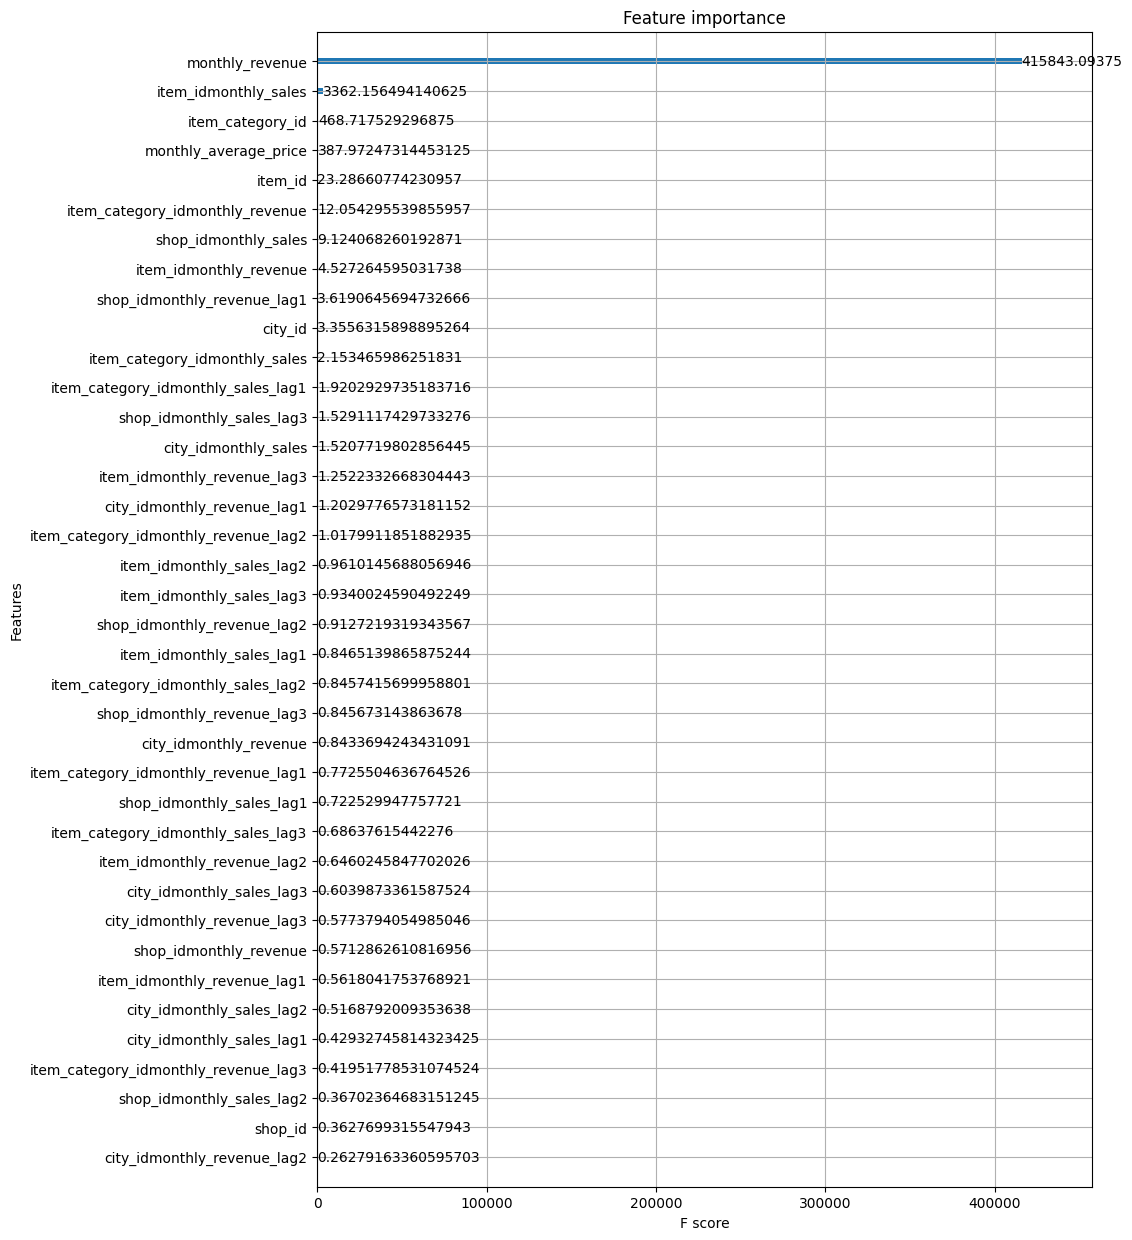

In [ ]:
importance = model.get_booster().get_score(importance_type = "gain")
importance = {k: v for k, v in sorted(importance.items(), key = lambda item: item[1])}

fig, ax = plt.subplots(figsize = (10, 15))
xgb.plot_importance(model, importance_type = "gain", ax = ax);

<a id='prediction'></a>
### Prediction
[Volver al índice](#index)<br>

En este apartado vamos a utilizar el modelo entrenado para hacer una predicción y posteriormente enviar el submit a Kaggle.

In [ ]:
if "monthly_sales" in X_test.columns:
    X_test.drop("monthly_sales", axis = 1, inplace = True)

Y_test_predict = model.predict(X_test)
X_test["monthly_sales"] = Y_test_predict

In [ ]:
X_test.reset_index(inplace = True)

In [ ]:
Y_train_predict = model.predict(X_train)
Y_valida_predict = model.predict(X_valida)

rmse_train = np.sqrt(
    mean_squared_error(
        y_true = Y_train,
        y_pred = Y_train_predict
    )
)

rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = Y_valida,
        y_pred = Y_valida_predict
    )
)

rmse_train= str(round(rmse_train, 3)).replace(".", "_")
rmse_valida = str(round(rmse_valida, 3)).replace(".", "_")

In [ ]:
print(f"Train RMSE: {rmse_train}")
print(f"Validation RMSE: {rmse_valida}")

Train RMSE: 0_143
Validation RMSE: 0_323


In [ ]:
(
    X_test[["unique_id", "monthly_sales"]]
    .to_csv(f"submission_train_{rmse_train}_valida_{rmse_valida}.csv", index = False)
)

<a id='conclusion'></a>
### Conclusión
[Volver al índice](#index)<br>

En este notebook hemos explorado la importancia en Machine Learning de utilizar un modelo benchmark cuando nos enfrentamos por primera vez a un nuevo dataset.

Establecer el benchmark nos ayuda a entender cual es el punto de partida.

Al entrenar un modelo, tenemos ya un notebook funcional que nos permite entrar en la siguiente loop:

1. Hacer un poco más de EDA.
1. Construir nuevas variables.
1. Probar estas variables en el modelo.
1. Guardar el score para ver la mejora o no (Kaggle Submit).
1. Volver al punto 1.

A continuación dejamos algunas ideas que los alumnos pueden implementar para mejorar el benchmark:

1. Probad otras combinaciones de variables.
1. Darle más profundidad a los lags/shifts.
1. Implementar medias móviles (ojo variables autoexplicativas).
1. Utilizar otras columnas en vez de MONTHLY_SALES para construir las variables.
1. Probar otros algoritmos.
1. Tunnear los hiperparametros del modelo.

### Happy Kaggling :)

<a id='referencias'></a>
### Referencias y lecturas recomendables
[Volver al índice](#index)<br>

A continuación dejamos algunos links útiles para profundizar en algunos de los conceptos que hemos visto en el notebook:

[The importance of Benchmarking](https://blog.bigml.com/2020/03/20/machine-learning-benchmarking-youre-doing-it-wrong/)

[Tree Based Models and Extrapolation (MUY RECOMENDABLE)](https://shanminlin.medium.com/how-to-help-tree-based-models-extrapolate-7954287b1219)

[XGBoost](https://xgboost.readthedocs.io/en/stable/)